In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [2]:
df = pd.read_csv('johor_senai_weather_data.csv')
df

,date,temp_celsius,temp_fahrenheit,condition,wind_speed_mph,pressure,humidity(%)
0,2014-01-01 00:00:00,23.888889,75,Mostly Cloudy,1,29.74,94
1,2014-01-01 01:00:00,23.888889,75,Mostly Cloudy,2,29.74,94
2,2014-01-01 02:00:00,23.888889,75,Mostly Cloudy,1,29.71,94
3,2014-01-01 03:00:00,23.888889,75,Mostly Cloudy,1,29.71,94
4,2014-01-01 04:00:00,23.888889,75,Mostly Cloudy,1,29.68,94
...,...,...,...,...,...,...,...
95184,2024-09-24 20:00:00,25.000000,77,Fair,2,29.65,94
95185,2024-09-24 21:00:00,25.000000,77,Fair,3,29.68,94
95186,2024-09-24 22:00:00,25.000000,77,Fair,3,29.68,94
95187,2024-09-24 23:00:00,25.000000,77,Fair,1,29.71,94


In [3]:
df.date = pd.to_datetime(df.date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95189 entries, 0 to 95188
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             95189 non-null  datetime64[ns]
 1   temp_celsius     95189 non-null  float64       
 2   temp_fahrenheit  95189 non-null  int64         
 3   condition        95189 non-null  object        
 4   wind_speed_mph   95189 non-null  int64         
 5   pressure         95189 non-null  float64       
 6   humidity(%)      95189 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 5.1+ MB


In [4]:
# Extract additional time features
df_encoded = df.copy()
df_encoded.drop(columns=['condition','temp_celsius'], inplace=True)
df_encoded['Month'] = df['date'].dt.month
df_encoded['Hour'] = df['date'].dt.hour
df_encoded.drop(columns=['date'], inplace=True)
df_encoded

,temp_fahrenheit,wind_speed_mph,pressure,humidity(%),Month,Hour
0,75,1,29.74,94,1,0
1,75,2,29.74,94,1,1
2,75,1,29.71,94,1,2
3,75,1,29.71,94,1,3
4,75,1,29.68,94,1,4
...,...,...,...,...,...,...
95184,77,2,29.65,94,9,20
95185,77,3,29.68,94,9,21
95186,77,3,29.68,94,9,22
95187,77,1,29.71,94,9,23


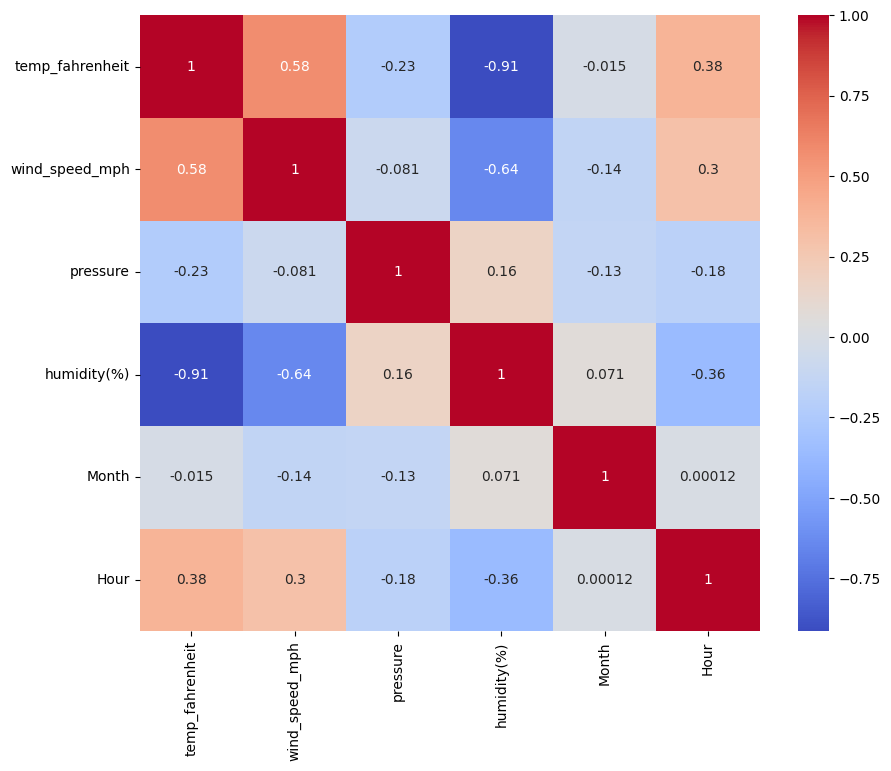

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm')
plt.show()

In [6]:
scaler = StandardScaler()
features_to_normalize = ['temp_fahrenheit', 'wind_speed_mph', 'pressure', 'humidity(%)']
df_encoded[features_to_normalize] = scaler.fit_transform(
    df_encoded[features_to_normalize]
)
df_encoded

,temp_fahrenheit,wind_speed_mph,pressure,humidity(%),Month,Hour
0,-1.137873,-0.945348,1.411699,0.713483,1,0
1,-1.137873,-0.591546,1.411699,0.713483,1,1
2,-1.137873,-0.945348,0.848748,0.713483,1,2
3,-1.137873,-0.945348,0.848748,0.713483,1,3
4,-1.137873,-0.945348,0.285796,0.713483,1,4
...,...,...,...,...,...,...
95184,-0.757526,-0.591546,-0.277156,0.713483,9,20
95185,-0.757526,-0.237744,0.285796,0.713483,9,21
95186,-0.757526,-0.237744,0.285796,0.713483,9,22
95187,-0.757526,-0.945348,0.848748,0.713483,9,23


In [7]:
scaler.inverse_transform(df_encoded[features_to_normalize])

array([[75.  ,  1.  , 29.74, 94.  ],
       [75.  ,  2.  , 29.74, 94.  ],
       [75.  ,  1.  , 29.71, 94.  ],
       ...,
       [77.  ,  3.  , 29.68, 94.  ],
       [77.  ,  1.  , 29.71, 94.  ],
       [77.  ,  2.  , 29.71, 94.  ]])

In [8]:
# Cyclic encoding for Month and Hour
df_encoded['Month_sin'] = np.sin(2 * np.pi * df_encoded['Month'] / 12)
df_encoded['Month_cos'] = np.cos(2 * np.pi * df_encoded['Month'] / 12)
df_encoded['Hour_sin'] = np.sin(2 * np.pi * df_encoded['Hour'] / 24)
df_encoded['Hour_cos'] = np.cos(2 * np.pi * df_encoded['Hour'] / 24)
# df_encoded.drop(columns=['temp_celsius'], inplace=True)
# df_encoded.drop(columns=['Month', 'Hour', 'Year', 'Day'], inplace=True)
df_encoded.drop(columns=['Month', 'Hour'], inplace=True)
df_encoded

,temp_fahrenheit,wind_speed_mph,pressure,humidity(%),Month_sin,Month_cos,Hour_sin,Hour_cos
0,-1.137873,-0.945348,1.411699,0.713483,0.5,8.660254e-01,0.000000,1.000000
1,-1.137873,-0.591546,1.411699,0.713483,0.5,8.660254e-01,0.258819,0.965926
2,-1.137873,-0.945348,0.848748,0.713483,0.5,8.660254e-01,0.500000,0.866025
3,-1.137873,-0.945348,0.848748,0.713483,0.5,8.660254e-01,0.707107,0.707107
4,-1.137873,-0.945348,0.285796,0.713483,0.5,8.660254e-01,0.866025,0.500000
...,...,...,...,...,...,...,...,...
95184,-0.757526,-0.591546,-0.277156,0.713483,-1.0,-1.836970e-16,-0.866025,0.500000
95185,-0.757526,-0.237744,0.285796,0.713483,-1.0,-1.836970e-16,-0.707107,0.707107
95186,-0.757526,-0.237744,0.285796,0.713483,-1.0,-1.836970e-16,-0.500000,0.866025
95187,-0.757526,-0.945348,0.848748,0.713483,-1.0,-1.836970e-16,-0.258819,0.965926


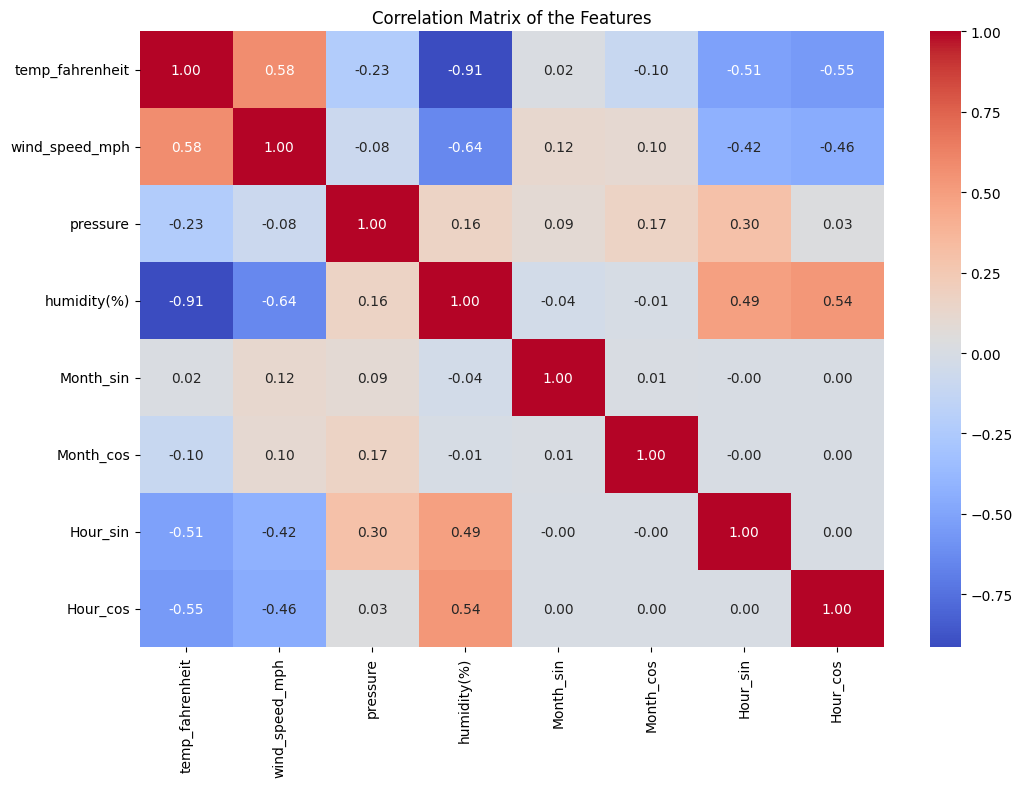

In [9]:
correlation_matrix = df_encoded.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f')

# Add a title
plt.title('Correlation Matrix of the Features')
plt.show()

In [10]:
df_encoded.describe()

,temp_fahrenheit,wind_speed_mph,pressure,humidity(%),Month_sin,Month_cos,Hour_sin,Hour_cos
count,9.518900e+04,9.518900e+04,9.518900e+04,9.518900e+04,9.518900e+04,9.518900e+04,95189.000000,9.518900e+04
mean,-9.267981e-16,8.957456e-19,6.959107e-14,3.153025e-16,7.395443e-03,-2.203246e-02,-0.006542,-6.839289e-03
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,7.076659e-01,7.061723e-01,0.707194,7.069637e-01
min,-2.849435e+00,-9.453477e-01,-3.467215e+00,-4.379135e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000e+00
25%,-7.575257e-01,-5.915458e-01,-6.524568e-01,-6.035730e-01,-5.000000e-01,-8.660254e-01,-0.707107,-7.071068e-01
50%,-3.771785e-01,-2.377438e-01,-2.771556e-01,2.744646e-01,1.224647e-16,-1.836970e-16,0.000000,-1.836970e-16
75%,5.736893e-01,4.698602e-01,8.487478e-01,7.134834e-01,8.660254e-01,5.000000e-01,0.707107,7.071068e-01
max,3.426293e+00,6.838296e+00,4.226458e+00,1.240306e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00


In [26]:
# Define a function to create sequences from the dataset
def create_sequences(data, seq_length=24):  # Changed seq_length to 24
    sequences = []
    targets = []

    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length, :4]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

# Convert your DataFrame to numpy array
data_values = df_encoded.values

# Set sequence length to 24
seq_length = 24

# Create sequences
X, y = create_sequences(data_values, seq_length)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [12]:
print(f'Sequences shape: {X_tensor.shape}')
print(f'Targets shape: {y_tensor.shape}')

Sequences shape: torch.Size([95165, 24, 8])
Targets shape: torch.Size([95165, 4])


In [13]:
# Define the split ratios
train_ratio = 0.85
val_ratio = 0.05
test_ratio = 0.10

# Total number of sequences
total_sequences = len(X_tensor)

# Calculate the indices for the splits
train_size = int(total_sequences * train_ratio)
val_size = int(total_sequences * val_ratio)

# Split the data
X_train, X_val, X_test = X_tensor[:train_size], X_tensor[train_size:train_size + val_size], X_tensor[train_size + val_size:]
y_train, y_val, y_test = y_tensor[:train_size], y_tensor[train_size:train_size + val_size], y_tensor[train_size + val_size:]

# Print the shapes of the split datasets
print(f'Training Sequences Shape: {X_train.shape}')
print(f'Validation Sequences Shape: {X_val.shape}')
print(f'Test Sequences Shape: {X_test.shape}')
print(f'Training Targets Shape: {y_train.shape}')
print(f'Validation Targets Shape: {y_val.shape}')
print(f'Test Targets Shape: {y_test.shape}')

Training Sequences Shape: torch.Size([80890, 24, 8])
Validation Sequences Shape: torch.Size([4758, 24, 8])
Test Sequences Shape: torch.Size([9517, 24, 8])
Training Targets Shape: torch.Size([80890, 4])
Validation Targets Shape: torch.Size([4758, 4])
Test Targets Shape: torch.Size([9517, 4])


In [14]:
# Create TensorDatasets for each set
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Define batch size
batch_size = 64  # Adjust based on your needs

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)      # No shuffle for validation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    # No shuffle for testing

# Check lengths
print(f'Total samples in train_dataset: {len(train_dataset)}')
print(f'Number of batches in train_loader: {len(train_loader)}')

print(f'Total samples in the val_dataset: {len(val_dataset)}')
print(f'Number of batches in val_loader: {len(val_loader)}')

print(f'Total samples in test_dataset: {len(test_dataset)}')
print(f'Number of batches in test_loader: {len(test_loader)}')

Total samples in train_dataset: 80890
Number of batches in train_loader: 1264
Total samples in the val_dataset: 4758
Number of batches in val_loader: 75
Total samples in test_dataset: 9517
Number of batches in test_loader: 149


In [15]:
# Define Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, nheads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nheads,
                                                        dim_feedforward=hidden_dim, dropout=0.1, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, output_dim)  # Fully connected layer for final output

    def forward(self, src):
        transformer_out = self.transformer(src)
        output = self.fc(transformer_out[:, -1, :])  # Output of the last time step
        return output

# Model hyperparameters
input_dim = X_tensor.shape[2]  # Number of features
hidden_dim = 512  # Hidden dimension size
nheads = 8  # Attention heads
num_layers = 4  # Number of layers
output_dim = 4  # We're predicting 4 features
# Instantiate the model
model = TransformerModel(input_dim, hidden_dim, nheads, num_layers, output_dim)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Loss function
criterion = nn.MSELoss()

# Early Stopping Mechanism
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0005):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Function to calculate metrics
def calculate_metrics(target, prediction):
    mae = mean_absolute_error(target.detach().cpu().numpy(), prediction.detach().cpu().numpy())
    mse = mean_squared_error(target.detach().cpu().numpy(), prediction.detach().cpu().numpy())
    rmse = np.sqrt(mse)
    r2 = r2_score(target.detach().cpu().numpy(), prediction.detach().cpu().numpy())
    return mae, rmse, r2

C:\Users\Nitro 5\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Instantiate EarlyStopping
early_stopping = EarlyStopping(patience=30, min_delta=0.0005)

# Training loop with scheduler and early stopping
epochs = 50  # You can adjust this as needed, early stopping will manage early termination
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for inputs, target in train_loader:
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()  # Zero gradients
        output = model(inputs)  # Forward pass
        loss = criterion(output.squeeze(), target)  # Compute loss
        loss.backward()  # Backpropagate
        optimizer.step()  # Update weights

        epoch_loss += loss.item()

    # Validation step
    model.eval()
    val_loss = 0
    val_targets = []
    val_outputs = []
    with torch.no_grad():
        for val_inputs, val_target in val_loader:
            val_inputs, val_target = val_inputs.to(device), val_target.to(device)
            val_output = model(val_inputs)
            val_loss += criterion(val_output.squeeze(), val_target).item()
            val_targets.append(val_target)
            val_outputs.append(val_output)

    val_loss /= len(val_loader)

    # Concatenate outputs and targets for metric calculation
    val_targets = torch.cat(val_targets)
    val_outputs = torch.cat(val_outputs)

    # Calculate metrics
    mae, rmse, r2 = calculate_metrics(val_targets, val_outputs)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss/len(train_loader)}, Val Loss: {val_loss}, MAE: {mae}, RMSE: {rmse}, R²: {r2}')

    # Adjust learning rate with scheduler
    scheduler.step(val_loss)

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 1/50, Train Loss: 0.22693017273669755, Val Loss: 0.15762064188718797, MAE: 0.28137707710266113, RMSE: 0.3977276384830475, R²: 0.8151508569717407
Epoch 2/50, Train Loss: 0.17856361503017287, Val Loss: 0.156056627035141, MAE: 0.28232112526893616, RMSE: 0.39554792642593384, R²: 0.8176804184913635
Epoch 3/50, Train Loss: 0.16864201536732196, Val Loss: 0.14865640153487522, MAE: 0.2700534462928772, RMSE: 0.3860231041908264, R²: 0.8261346817016602
Epoch 4/50, Train Loss: 0.16300216805826448, Val Loss: 0.1468784576654434, MAE: 0.2713565230369568, RMSE: 0.38373300433158875, R²: 0.8282185792922974
Epoch 5/50, Train Loss: 0.15951852439136444, Val Loss: 0.1441758715113004, MAE: 0.26673710346221924, RMSE: 0.3801749050617218, R²: 0.8309813737869263
Epoch 6/50, Train Loss: 0.15748707309978294, Val Loss: 0.14109638343254724, MAE: 0.2602670192718506, RMSE: 0.376160204410553, R²: 0.8341804146766663
Epoch 7/50, Train Loss: 0.15564144122166723, Val Loss: 0.14202583889166515, MAE: 0.2628290057182312,

In [17]:
def calculate_metrics_per_feature(y_true, y_pred):
    metrics = {}
    for i in range(y_true.shape[1]):  # Iterate over each feature
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        rmse = mean_squared_error(y_true[:, i], y_pred[:, i], squared=False)
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        metrics[f'Feature {i}'] = {
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2
        }
    return metrics

# Evaluation on the test set
model.eval()
test_loss = 0
test_targets = []
test_outputs = []

with torch.no_grad():
    for test_inputs, test_target in test_loader:
        test_inputs, test_target = test_inputs.to(device), test_target.to(device)
        test_output = model(test_inputs)
        test_loss += criterion(test_output.squeeze(), test_target).item()
        test_targets.append(test_target)
        test_outputs.append(test_output)

test_loss /= len(test_loader)

# Concatenate outputs and targets for metric calculation
test_targets = torch.cat(test_targets).cpu().numpy()  # Convert to NumPy
test_outputs = torch.cat(test_outputs).cpu().numpy()

# Calculate metrics for each feature
metrics_per_feature = calculate_metrics_per_feature(test_targets, test_outputs)

# Print metrics
for feature, metrics in metrics_per_feature.items():
    print(f'{feature} - MAE: {metrics["MAE"]}, RMSE: {metrics["RMSE"]}, R²: {metrics["R²"]}')

Feature 0 - MAE: 0.19879581034183502, RMSE: 0.28136950731277466, R²: 0.9150713086128235
Feature 1 - MAE: 0.3924054205417633, RMSE: 0.595329999923706, R²: 0.6535500288009644
Feature 2 - MAE: 0.2152801901102066, RMSE: 0.26567792892456055, R²: 0.9308109283447266
Feature 3 - MAE: 0.25416240096092224, RMSE: 0.35173189640045166, R²: 0.8815242052078247


C:\Users\Nitro 5\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Nitro 5\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Nitro 5\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Nitro 5\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: Futu

In [18]:
scaler.inverse_transform(test_outputs)

array([[89.49383  ,  7.549939 , 29.60858  , 66.23075  ],
       [90.55447  ,  7.169062 , 29.608448 , 61.768124 ],
       [83.30654  ,  6.2327423, 29.617685 , 80.33111  ],
       ...,
       [76.5055   ,  2.4473808, 29.69409  , 94.44423  ],
       [76.59613  ,  2.5121408, 29.6906   , 94.20692  ],
       [76.54887  ,  1.6241366, 29.706203 , 94.599106 ]], dtype=float32)

In [19]:
scaler.inverse_transform(test_outputs[:, :])

array([[89.49383  ,  7.549939 , 29.60858  , 66.23075  ],
       [90.55447  ,  7.169062 , 29.608448 , 61.768124 ],
       [83.30654  ,  6.2327423, 29.617685 , 80.33111  ],
       ...,
       [76.5055   ,  2.4473808, 29.69409  , 94.44423  ],
       [76.59613  ,  2.5121408, 29.6906   , 94.20692  ],
       [76.54887  ,  1.6241366, 29.706203 , 94.599106 ]], dtype=float32)

Actual                                             Predicted  \
  temp_fahrenheit wind_speed_mph   pressure humidity(%) temp_fahrenheit   
0            91.0            8.0  29.629999        59.0       89.493828   
1            86.0            8.0  29.629999        74.0       90.554466   
2            82.0            7.0  29.629999        79.0       83.306541   
3            81.0            3.0  29.629999        89.0       80.655350   
4            81.0            5.0  29.629999        89.0       80.666786   

                                         
  wind_speed_mph   pressure humidity(%)  
0       7.549939  29.608580   66.230751  
1       7.169062  29.608448   61.768124  
2       6.232742  29.617685   80.331108  
3       5.121642  29.625780   84.508400  
4       3.304220  29.632244   88.539322

Feature 0 - MAE: 1.045338749885559, RMSE: 1.479540467262268, R²: 0.9150713086128235
Feature 1 - MAE: 1.1091102361679077, RMSE: 1.682664394378662, R²: 0.6535500288009644
Feature 2 - MAE: 0.011472320184111595, RMSE: 0.014158030971884727, R²: 0.9308116436004639
Feature 3 - MAE: 2.894664764404297, RMSE: 4.005886554718018, R²: 0.8815242648124695


C:\Users\Nitro 5\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Nitro 5\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Nitro 5\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Nitro 5\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: Futu

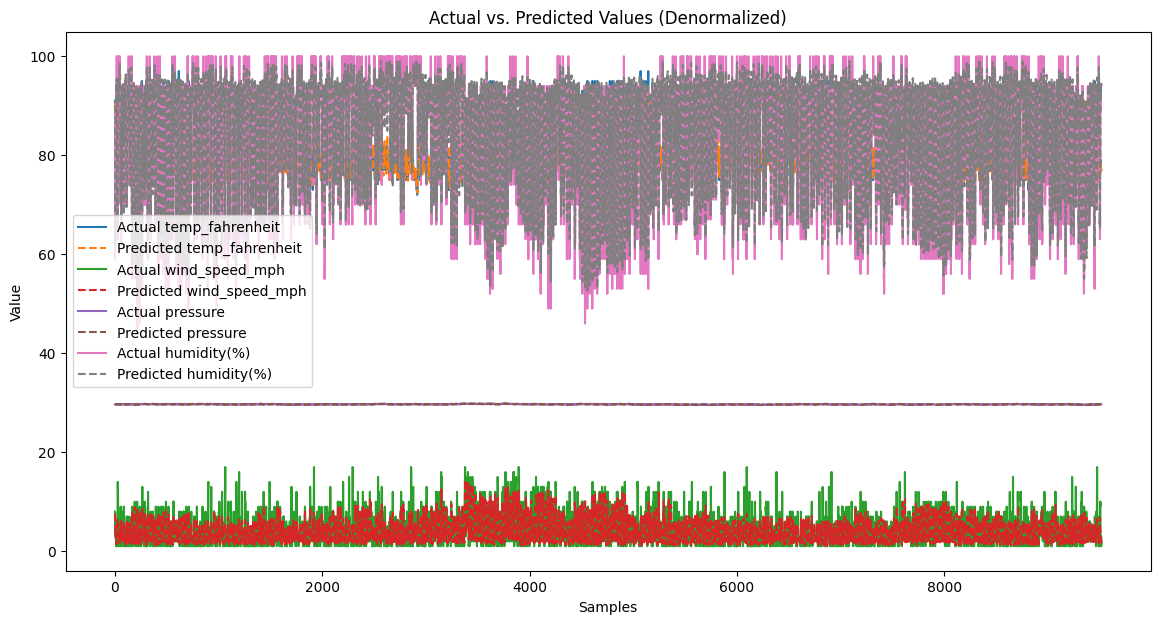

In [20]:
## Assuming 'scaler' is your StandardScaler instance used earlier
# The features that were normalized
normalized_features = ['temp_fahrenheit', 'wind_speed_mph', 'pressure', 'humidity(%)']

# Step 1: Denormalize the predicted outputs (only the normalized features)
# Create a new array for the denormalized outputs
denormalized_outputs = np.zeros_like(test_outputs)

# Denormalize only the normalized features
denormalized_outputs[:, :len(normalized_features)] = scaler.inverse_transform(test_outputs[:, :len(normalized_features)])

# Copy the condition features directly without denormalization
denormalized_outputs[:, len(normalized_features):] = test_outputs[:, len(normalized_features):]

# Denormalize the actual targets for comparison
denormalized_targets = np.zeros_like(test_targets)

# Denormalize only the normalized features
denormalized_targets[:, :len(normalized_features)] = scaler.inverse_transform(test_targets[:, :len(normalized_features)])

# Copy the condition features directly without denormalization
denormalized_targets[:, len(normalized_features):] = test_targets[:, len(normalized_features):]

# Create DataFrames for comparison
denormalized_outputs_df = pd.DataFrame(denormalized_outputs, columns=normalized_features)
denormalized_targets_df = pd.DataFrame(denormalized_targets, columns=normalized_features)

# Concatenate for comparison
comparison_df = pd.concat([denormalized_targets_df, denormalized_outputs_df],
                           axis=1,
                           keys=['Actual', 'Predicted'])

# Print out the comparison DataFrame
display(comparison_df.head())

# Optional: Calculate metrics again on denormalized data if needed
denormalized_metrics_per_feature = calculate_metrics_per_feature(denormalized_targets, denormalized_outputs)

# Print metrics for denormalized values
for feature, metrics in denormalized_metrics_per_feature.items():
    print(f'{feature} - MAE: {metrics["MAE"]}, RMSE: {metrics["RMSE"]}, R²: {metrics["R²"]}')

# Visualize the comparison
plt.figure(figsize=(14, 7))
for feature in normalized_features:
    plt.plot(comparison_df[('Actual', feature)], label=f'Actual {feature}')
    plt.plot(comparison_df[('Predicted', feature)], label=f'Predicted {feature}', linestyle='--')

plt.title('Actual vs. Predicted Values (Denormalized)')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()


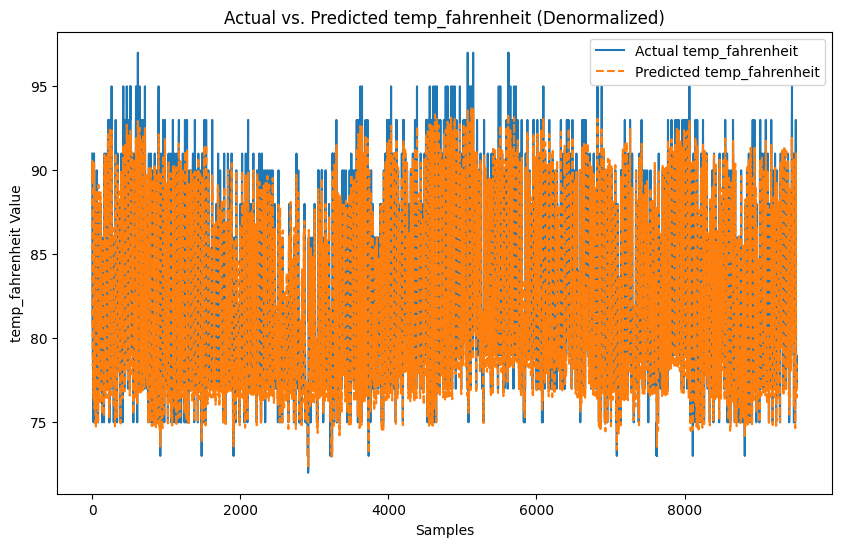

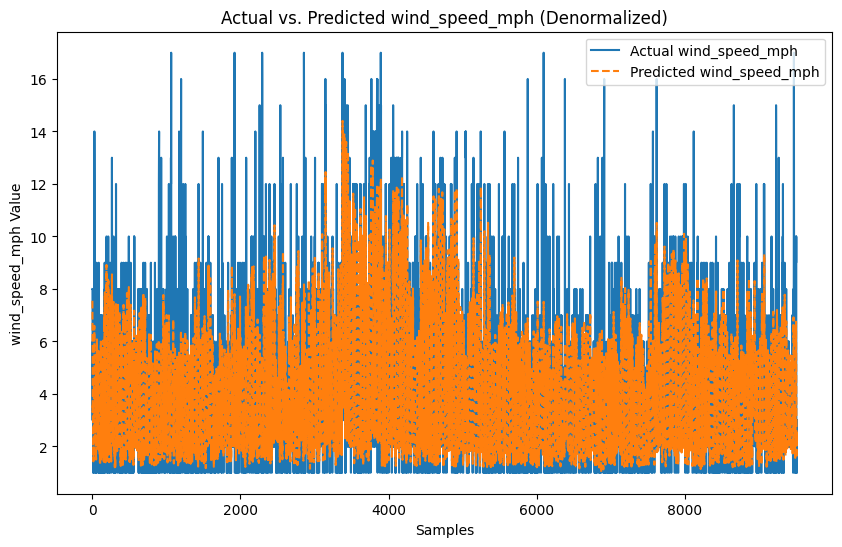

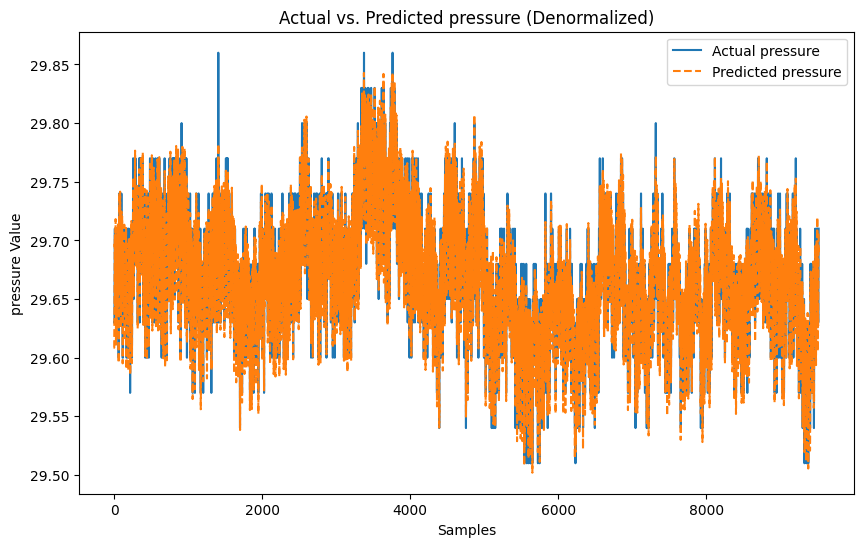

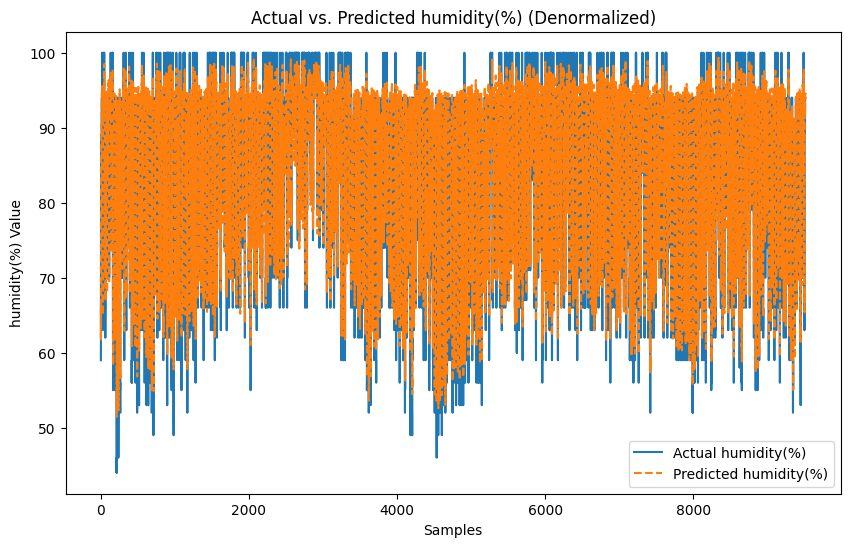

In [24]:
import matplotlib.pyplot as plt

# List of the features to plot individually
features = normalized_features

# Create a figure for each feature
for feature in features:
    plt.figure(figsize=(10, 6))
    plt.plot(comparison_df[('Actual', feature)], label=f'Actual {feature}')
    plt.plot(comparison_df[('Predicted', feature)], label=f'Predicted {feature}', linestyle='--')
    
    plt.title(f'Actual vs. Predicted {feature} (Denormalized)')
    plt.xlabel('Samples')
    plt.ylabel(f'{feature} Value')
    plt.legend()
    plt.show()


In [30]:
torch.save(model.state_dict(), 'transformer_model_50epochs.pth')

In [31]:
torch.save(model, 'tfm_model_50epochs.pth')

In [32]:
# Load the entire model
loaded_model = torch.load('tfm_model_50epochs.pth')

# Set the model to evaluation mode (if you are using it for inference)
loaded_model.eval()

TransformerModel(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
    )
    (linear1): Linear(in_features=8, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=8, bias=True)
    (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
        )
        (linear1): Linear(in_features=8, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_

In [33]:
# Evaluation on the test set
test_loss = 0
test_targets = []
test_outputs = []

with torch.no_grad():
    for test_inputs, test_target in test_loader:
        test_inputs, test_target = test_inputs.to(device), test_target.to(device)
        test_output = loaded_model(test_inputs)
        test_loss += criterion(test_output.squeeze(), test_target).item()
        test_targets.append(test_target)
        test_outputs.append(test_output)

test_loss /= len(test_loader)

# Concatenate outputs and targets for metric calculation
test_targets = torch.cat(test_targets).cpu().numpy()  # Convert to NumPy
test_outputs = torch.cat(test_outputs).cpu().numpy()

# Calculate metrics for each feature
metrics_per_feature = calculate_metrics_per_feature(test_targets, test_outputs)

# Print metrics 
for feature, metrics in metrics_per_feature.items():
    print(f'{feature} - MAE: {metrics["MAE"]}, RMSE: {metrics["RMSE"]}, R²: {metrics["R²"]}')

Feature 0 - MAE: 0.19879581034183502, RMSE: 0.28136950731277466, R²: 0.9150713086128235
Feature 1 - MAE: 0.3924054205417633, RMSE: 0.595329999923706, R²: 0.6535500288009644
Feature 2 - MAE: 0.2152801901102066, RMSE: 0.26567792892456055, R²: 0.9308109283447266
Feature 3 - MAE: 0.25416240096092224, RMSE: 0.35173189640045166, R²: 0.8815242052078247


C:\Users\Nitro 5\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Nitro 5\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Nitro 5\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Nitro 5\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: Futu

In [34]:
data_last_24_hours = df[-24:]
data_last_24_hours.drop(columns=['temp_celsius', 'condition'], inplace=True)

C:\Users\Nitro 5\AppData\Local\Temp\ipykernel_106892\368336845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_last_24_hours.drop(columns=['temp_celsius', 'condition'], inplace=True)


In [35]:
data_last_24_hours[1:]

,date,temp_fahrenheit,wind_speed_mph,pressure,humidity(%)
95166,2024-09-24 06:00:00,75,1,29.68,94
95167,2024-09-24 07:00:00,75,2,29.68,94
95168,2024-09-24 08:00:00,77,2,29.71,94
95169,2024-09-24 09:00:00,81,1,29.71,89
95170,2024-09-24 10:00:00,86,2,29.71,79
95171,2024-09-24 11:00:00,88,2,29.71,75
95172,2024-09-24 12:00:00,91,5,29.68,66
95173,2024-09-24 13:00:00,93,6,29.65,67
95174,2024-09-24 14:00:00,93,7,29.63,63
95175,2024-09-24 14:07:00,93,7,29.63,63


In [36]:
def process_weather_data(df_default, scaler_fuc):
    """
    Process the weather DataFrame to normalize specific features
    and add sine and cosine transformations for month and hour.

    Parameters:
    df (pd.DataFrame): DataFrame containing weather data with a 'date' column.

    Returns:
    pd.DataFrame: A single-row DataFrame with normalized values and sine/cosine transformations.
    """
    df = df_default.copy()
    # Convert 'date' to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Extract month and hour
    df['month'] = df['date'].dt.month
    df['hour'] = df['date'].dt.hour

    # Add sine and cosine transformations
    df['Month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['Hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Normalize specified features
    features_to_normalize = ['temp_fahrenheit', 'wind_speed_mph', 'pressure', 'humidity(%)']
    df[features_to_normalize] = scaler_fuc.transform(df[features_to_normalize])
    df.drop(columns=['date', 'month', 'hour'], inplace=True)

    return np.array(df)

process_weather_data(data_last_24_hours, scaler)

array([[-1.13787279e+00, -9.45347742e-01,  2.85796065e-01,
         7.13483367e-01, -1.00000000e+00, -1.83697020e-16,
         9.65925826e-01,  2.58819045e-01],
       [-1.13787279e+00, -9.45347742e-01,  2.85796065e-01,
         7.13483367e-01, -1.00000000e+00, -1.83697020e-16,
         1.00000000e+00,  6.12323400e-17],
       [-1.13787279e+00, -5.91545750e-01,  2.85796065e-01,
         7.13483367e-01, -1.00000000e+00, -1.83697020e-16,
         9.65925826e-01, -2.58819045e-01],
       [-7.57525661e-01, -5.91545750e-01,  8.48747779e-01,
         7.13483367e-01, -1.00000000e+00, -1.83697020e-16,
         8.66025404e-01, -5.00000000e-01],
       [ 3.16859377e-03, -9.45347742e-01,  8.48747779e-01,
         2.74464574e-01, -1.00000000e+00, -1.83697020e-16,
         7.07106781e-01, -7.07106781e-01],
       [ 9.54036412e-01, -5.91545750e-01,  8.48747779e-01,
        -6.03573011e-01, -1.00000000e+00, -1.83697020e-16,
         5.00000000e-01, -8.66025404e-01],
       [ 1.33438354e+00, -5.915457

In [38]:
a = True
data_last_24_hours = df.copy()[-24:]
data_last_24_hours.drop(columns=['temp_celsius', 'condition'], inplace=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predicted_df = pd.DataFrame(columns=data_last_24_hours.columns)
# Load the entire model
loaded_model = torch.load('tfm_model_50epochs.pth')

while a:
    X_tensor = torch.tensor(process_weather_data(data_last_24_hours, scaler), dtype=torch.float32)
    # print(f'Sequences shape: {X_tensor.shape}')
    X_tensor = X_tensor.unsqueeze(0).to(device)
    loaded_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        predictions = loaded_model(X_tensor)

    predictions = scaler.inverse_transform(predictions.cpu().numpy()).squeeze()
    last_timestamp = data_last_24_hours['date'].iloc[-1]
    future_date = last_timestamp + pd.Timedelta(hours=1)
    new_row = pd.DataFrame([[future_date] + predictions.tolist()], columns=data_last_24_hours.columns)
    predicted_df = pd.concat([predicted_df, new_row], ignore_index=True)
    data_last_24_hours = pd.concat([data_last_24_hours, new_row], ignore_index=True)
    data_last_24_hours = data_last_24_hours[1:]
    print(future_date)
    if data_last_24_hours.date.iloc[-1].year > 2024 and data_last_24_hours.date.iloc[-1].month > 6:
      a = False
      # display(data_last_24_hours.date[-1].year)

C:\Users\Nitro 5\AppData\Local\Temp\ipykernel_106892\931261043.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_df = pd.concat([predicted_df, new_row], ignore_index=True)


2024-09-25 01:00:00
2024-09-25 02:00:00
2024-09-25 03:00:00
2024-09-25 04:00:00
2024-09-25 05:00:00
2024-09-25 06:00:00
2024-09-25 07:00:00
2024-09-25 08:00:00
2024-09-25 09:00:00
2024-09-25 10:00:00
2024-09-25 11:00:00
2024-09-25 12:00:00
2024-09-25 13:00:00
2024-09-25 14:00:00
2024-09-25 15:00:00
2024-09-25 16:00:00
2024-09-25 17:00:00
2024-09-25 18:00:00
2024-09-25 19:00:00
2024-09-25 20:00:00
2024-09-25 21:00:00
2024-09-25 22:00:00
2024-09-25 23:00:00
2024-09-26 00:00:00
2024-09-26 01:00:00
2024-09-26 02:00:00
2024-09-26 03:00:00
2024-09-26 04:00:00
2024-09-26 05:00:00
2024-09-26 06:00:00
2024-09-26 07:00:00
2024-09-26 08:00:00
2024-09-26 09:00:00
2024-09-26 10:00:00
2024-09-26 11:00:00
2024-09-26 12:00:00
2024-09-26 13:00:00
2024-09-26 14:00:00
2024-09-26 15:00:00
2024-09-26 16:00:00
2024-09-26 17:00:00
2024-09-26 18:00:00
2024-09-26 19:00:00
2024-09-26 20:00:00
2024-09-26 21:00:00
2024-09-26 22:00:00
2024-09-26 23:00:00
2024-09-27 00:00:00
2024-09-27 01:00:00
2024-09-27 02:00:00


In [39]:
predicted_df['celcius'] = (predicted_df['temp_fahrenheit'] - 32) * 5/9
predicted_df

,date,temp_fahrenheit,wind_speed_mph,pressure,humidity(%),celcius
0,2024-09-25 01:00:00,76.354218,2.106690,29.696148,94.868637,24.641232
1,2024-09-25 02:00:00,75.831619,2.151681,29.677549,95.581886,24.350900
2,2024-09-25 03:00:00,75.547729,2.140491,29.661406,96.143105,24.193183
3,2024-09-25 04:00:00,75.376274,2.094040,29.650433,96.432396,24.097930
4,2024-09-25 05:00:00,75.325226,2.047243,29.648462,96.230789,24.069570
...,...,...,...,...,...,...
6691,2025-06-30 20:00:00,87.264038,3.115042,29.526199,70.987701,30.702243
6692,2025-06-30 21:00:00,85.294487,2.471516,29.547024,76.605080,29.608048
6693,2025-06-30 22:00:00,83.568123,2.167105,29.564064,81.989082,28.648957
6694,2025-06-30 23:00:00,82.262222,1.996670,29.575102,86.097595,27.923457


In [40]:
predicted_df.to_csv('predict_temp.csv', index=False)